In [ ]:
# !brew install poppler tesseract libmagic
#install globally
#brew install tesseract poppler libmagic
# echo 'export PATH="/opt/homebrew/bin:$PATH"' >> ~/.zshrc
# source ~/.zshrc

In [ ]:
import os
import uuid
from dotenv import load_dotenv
from PIL import Image
from io import BytesIO
import base64

from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.embeddings import OllamaEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.documents import Document
from langchain_community.chat_models.ollama import ChatOllama
from unstructured.partition.pdf import partition_pdf
from unstructured.documents.elements import Table, CompositeElement
from langchain_core.messages import SystemMessage, HumanMessage

In [ ]:
load_dotenv()

In [ ]:
import os

os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

In [ ]:
import subprocess
import sys

# Check if tesseract is accessible
try:
    result = subprocess.run(["tesseract", "--version"], capture_output=True, text=True)
    print("Tesseract version:", result.stdout)
except FileNotFoundError:
    print("Tesseract not found in PATH")

# Check PATH
import os

print("Current PATH:", os.environ.get("PATH", ""))

In [60]:
# file_path = "./content/attention.pdf"
output_path = "./content/"
file_path = output_path + "PIWPS009 - Assign FIN.pdf"

chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,
    strategy="hi_res",
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000,
)

In [61]:
# === Extract Content ===
tables, texts = [], []

for chunk in chunks:
    if isinstance(chunk, Table):
        tables.append(chunk)
    elif isinstance(chunk, CompositeElement):
        texts.append(chunk)
        for el in getattr(chunk.metadata, "orig_elements", []):
            if isinstance(el, Table):
                tables.append(el)
            # if hasattr(el.metadata, "image_base64"):
            #     images.append(el.metadata.image_base64)

In [62]:
tables

In [78]:
texts[0].to_dict()

{'type': 'CompositeElement',
 'element_id': '8ec5def785779d83ebc48acba3ed5388',
 'text': 'THE GOVERNMENT OF THE REPUBLIC OF SINGAPORE MINISTRY OF MANPOWER\n\nLEADING EDGE CAPABILITY PROGRAM IWPS\n\nPIWPS009 – Assign FIN\n\nVersion 1.0\n\n03 Jul 2025\n\n° (¢ MINISTRY OF\n\n> accenture\n\nLEAP - IWPS Page Definition: PIWPS 009 – Assign FIN\n\nVersion Control\n\n0.1 Document Information\n\nPrepared By Dave Lee Date Prepared 21 Jun 2001 Reviewed By Kong Teck Siong Date Reviewed 9 Jul 2001\n\n0.2 Version History\n\nDate Version Author Description of Changes Number 21 Jun 2001 0.1 Dave Lee Creation of document 8 Jul 2001 0.2 Garry Revision 31 July 2001 1.0 Garry Revision 01 Aug 2009 1.1 Deepa Removal of Distribution List as requested by ISTD (Reference: Minutes of HP-ISTD Monthly Mtg on 17 Apr 09, action item #7.1)\n\n> accenture\n\nConfidential\n\nConfidential\n\nPage 2 of 11\n\nqi ( MINISTRY OF\n\nLEAP - IWPS Page Definition: PIWPS 009 – Assign FIN\n\nTable of Contents\n\nVERSION CONTROL..

In [79]:
# Get the images from the CompositeElement objects
images = []
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64


images = get_images_base64(chunks)

In [84]:
images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCADiAc8DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACkpaQ9aADv0pD1qhrWrW2iaZNf3bERRDOAMlj2A9/wDPFeN6p8Udeu7otYutjbjG2IKrsfqxHWuihhqlb4Dlr4unR0lue6Uorxvw58U75LxYdd2z27nHnIgVo/wHX3+v5+wQSJ

In [65]:
# === LLM for Text + Table Summarization ===
text_model = ChatOllama(model="llama3:8b", temperature=0.5)

In [66]:
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.
Respond only with the summary and do not start with any introduction like here is the concise summary.
Table or text chunk: {element}
"""
text_prompt = ChatPromptTemplate.from_template(prompt_text)
summarize_chain = (
    {"element": lambda x: x} | text_prompt | text_model | StrOutputParser()
)

text_summaries = summarize_chain.batch(texts)
table_summaries = summarize_chain.batch([t.metadata.text_as_html for t in tables])

In [67]:
text_summaries

['This is the LEADING EDGE CAPABILITY PROGRAM IWPS document, specifically page definition PIWPS 009 - Assign FIN. The document outlines version control history, a table of contents, and provides an overview of the page description and screenshot for assigning financial information.',
 'This document defines the page for creating or amending a Foreign Identification Number (FIN) in LEAP - IWPS. The page allows users to assign, amend, or update FIN numbers and retrieve worker details using their WP number. It also provides options to generate new FIN numbers or stop automatic generation after 4 days.',
 'Modes: CREATE generates a FIN for workers, while AMEND allows users to key in or replace existing FINs. Validation rules include unique FIN numbers, valid formats, and no duplicates. Notifications are triggered when an invalid or duplicate FIN is entered, or when the threshold value is reached. Fields defined include Page ID, WP Number, FIN, Name, Date of Birth, Sex, Nationality, Passpor

In [68]:
table_summaries

['This table shows the prepared by and reviewed by details, with Dave Lee preparing it on June 21, 2001, and Kong Teck Siong reviewing it on July 9, 2001.',
 'The table shows a history of changes to a document, with updates made by Dave Lee, Garry, and Deepa between June 2001 and August 2009. The main changes include the creation of the document (0.1), revisions (0.2 and 1.0), and removal of a Distribution List as requested by ISTD.',
 'The table appears to be a contents page for a document, with headings such as "VERSION CONTROL", "OVERVIEW", "BACKGROUND FOR PAGE DEFINITION", "SCOPE OF DOCUMENT", and others. The content is mostly composed of repeated sequences of letters, making it difficult to decipher specific information.',
 'The table contains personal information about Tan Li Lian, including her name, date of birth, sex, nationality, and identification numbers.',
 'The table describes two modes: CREATE and AMEND. The CREATE mode generates a FIN for a worker, while the AMEND mode 

In [69]:
VISION_MODEL = "gemma3:12b"  # For image analysis (alternatives: llava:7b, bakllava)
EMBEDDING_MODEL = "nomic-embed-text"  # For embeddings
vision_model = ChatOllama(
    model=VISION_MODEL, temperature=0.3, base_url="http://localhost:11434"
)

In [70]:
def analyze_image_with_ollama(image_base64: str) -> str:
    """
    Analyze image using Ollama vision model
    Note: This approach works with models like llava that support vision
    """
    prompt_template = """Describe this image in detail. For context, 
    the image is part of a research paper explaining the transformers 
    architecture. Be specific about graphs, such as bar plots, diagrams, 
    and any text or mathematical formulas visible in the image."""

    # Create message with image
    messages = [
        HumanMessage(
            content=[
                {"type": "text", "text": prompt_template},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"},
                },
            ]
        )
    ]

    try:
        response = vision_model.invoke(messages)
        print(f"==>> response: {response}")
        return response.content
    except Exception as e:
        print(f"Error analyzing image: {e}")
        return f"Error analyzing image: Unable to process with {VISION_MODEL}"

In [71]:
image_summaries = []
for i, img_b64 in enumerate(images):
    print(f"Processing image {i+1}/{len(images)}")
    summary = analyze_image_with_ollama(img_b64)
    image_summaries.append(summary)

Processing image 1/3
==>> response: content='Okay, let\'s break down this image, which depicts a core component of the Transformer architecture. It\'s a diagram illustrating the flow of data through a Transformer block.\n\n**Overall Structure**\n\nThe image shows a block diagram representing a Transformer layer. It\'s structured as a series of interconnected boxes, each representing a specific operation or module within the Transformer. The diagram is split into two main paths, representing the flow of data through the layer.\n\n**Components and Flow (Left Side - Input Path)**\n\n1.  **Inputs:** This is the starting point. It represents the input sequence (e.g., a sequence of words in a sentence).\n2.  **Input Embedding:** This box represents the process of converting the input tokens (words, subwords, etc.) into vector representations (embeddings). This is a learned lookup table that maps each token to a dense vector.\n3.  **Positional Encoding:** This is a crucial addition. Transform

In [ ]:
image_summaries

In [ ]:
EMBEDDING_MODEL = "nomic-embed-text"
embeddings = OllamaEmbeddings(model=EMBEDDING_MODEL, base_url="http://localhost:11434")

In [ ]:
vectorstore = Chroma(
    collection_name="multi_modal_rag_ollama",
    embedding_function=embeddings,
    persist_directory="./chroma_db_ollama4",  # Separate directory for Ollama version
)

# Storage setup (unchanged)
store = InMemoryStore()
# store = LocalFileStore("./document_store_ollama")  # Alternative persistent storage
id_key = "doc_id"

In [ ]:
# MultiVector Retriever setup (unchanged)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [ ]:
print("Adding texts to retriever...")
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]})
    for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

print("Adding tables to retriever...")
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]})
    for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

print("Adding images to retriever...")
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]})
    for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

### Check In memory store data - 15 data

In [ ]:
# Get all the keys currently in the store
all_doc_ids = store.yield_keys()

# Loop through and fetch each document by its ID
for doc_id in all_doc_ids:
    docs = store.mget([doc_id])  # Returns a list with the document(s)
    print(f"Document ID: {doc_id}")
    for doc in docs:
        print(doc)  # `doc` is a Document object

### check Chroma document - 15 data

In [ ]:
all_docs = vectorstore.get()

index = 0
for doc in all_docs["documents"]:
    print("index is :", index)
    print(doc)
    index = index + 1

In [ ]:
print("Multi-modal RAG setup complete!")
print(f"Processed: {len(texts)} texts, {len(tables)} tables, {len(images)} images")

In [ ]:
retriever.search_kwargs = {"k":4}

In [ ]:
docs = retriever.invoke("what is multihead attention?")

In [ ]:
docs

### Print the formatted result

In [ ]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatOllama
from base64 import b64decode
import base64

In [ ]:
# Configuration - Choose your preferred model
RAG_MODEL = (
    "llama3.1:8b"  # Recommended alternatives: "llama3.2:3b", "mistral:7b", "qwen2:7b"
)
VISION_MODEL = "gemma3:12b"  # For handling images in RAG

print(f"Using RAG model: {RAG_MODEL}")
print(f"Using Vision model: {VISION_MODEL}")

In [ ]:
def parse_docs(docs):
    """
    Split retrieved documents into base64-encoded images and text content

    Args:
        docs: List of retrieved documents from the vector store

    Returns:
        dict: Contains separated 'images' and 'texts' lists
    """
    print(f"Processing {len(docs)} retrieved documents")

    b64_images = []
    text_docs = []

    for doc in docs:
        print(f"==>> doc: {doc}")
        # Check if document content is base64 encoded (likely an image)
        try:
            # Try to decode as base64
            # decoded = b64decode(doc.page_content)
            b64decode(doc)
            # If successful, it's likely base64 encoded image data
            b64_images.append(doc)
            print(f"Found base64 image document")
        except Exception as e:
            # If decoding fails, treat as text
            text_docs.append(doc)
            print(f"Found text document: {doc}...")

    return {"images": b64_images, "texts": text_docs}

In [ ]:
def build_prompt_text_only(kwargs):
    """
    Build prompt for text-only RAG (when no images are present)
    Uses the main RAG model for faster processing
    """
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    # Combine all text content
    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_doc in docs_by_type["texts"]:
            # Handle both string content and Document objects
            if hasattr(text_doc, "page_content"):
                context_text += text_doc.page_content + "\n\n"
            else:
                context_text += str(text_doc) + "\n\n"

    # Simple text-based prompt template
    prompt_template = f"""You are a helpful assistant answering questions based on the provided context.

Context:
{context_text.strip()}

Question: {user_question}

Instructions:
- Answer based only on the provided context
- If the context doesn't contain relevant information, say "I don't have enough information to answer this question based on the provided context"
- Be concise and accurate
- If referencing specific data or facts, mention them clearly

Answer:"""

    return ChatPromptTemplate.from_template(prompt_template)

In [ ]:
def build_prompt_with_vision(kwargs):
    """
    Build prompt for multi-modal RAG (when images are present)
    Uses the vision model to handle both text and images
    """
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    # Combine text content
    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_doc in docs_by_type["texts"]:
            if hasattr(text_doc, "page_content"):
                context_text += text_doc.page_content + "\n\n"
            else:
                context_text += str(text_doc) + "\n\n"

    # Base prompt text
    prompt_text = f"""You are a helpful assistant answering questions based on the provided context, which includes both text and images.

Text Context:
{context_text.strip()}

Question: {user_question}

Instructions:
- Answer based on both the text context and the images provided
- If analyzing images, describe what you see that's relevant to the question
- Be specific about information from images (charts, diagrams, etc.)
- If the context doesn't contain relevant information, say so clearly

Answer:"""

    # Build content list starting with text
    prompt_content = [{"type": "text", "text": prompt_text}]

    # Add images if present
    if len(docs_by_type["images"]) > 0:
        print(f"Adding {len(docs_by_type['images'])} images to prompt")
        for i, image_b64 in enumerate(docs_by_type["images"]):
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_b64}"},
                }
            )

    return ChatPromptTemplate.from_messages([HumanMessage(content=prompt_content)])

In [ ]:
def choose_model_and_prompt(kwargs):
    """
    Dynamically choose between text-only and vision model based on content
    """
    docs_by_type = kwargs["context"]
    print(f"==>> docs_by_type: {docs_by_type}")

    if len(docs_by_type["images"]) > 0:
        # Use vision model for multi-modal content
        print("Using vision model for multi-modal RAG")
        prompt = build_prompt_with_vision(kwargs)
        model = ChatOllama(
            model=VISION_MODEL, temperature=0.1, base_url="http://localhost:11434"
        )
    else:
        # Use text model for text-only content (faster)
        print("Using text model for text-only RAG")
        prompt = build_prompt_text_only(kwargs)
        model = ChatOllama(
            model=RAG_MODEL, temperature=0.1, base_url="http://localhost:11434"
        )

    return prompt | model | StrOutputParser()

In [ ]:
# Main RAG Chain
print("Setting up RAG chain...")
chain = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnableLambda(choose_model_and_prompt)

# Alternative: Simple chain that always uses text model (faster but no vision)
simple_text_chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt_text_only)
    | ChatOllama(model=RAG_MODEL, temperature=0.1, base_url="http://localhost:11434")
    | StrOutputParser()
)

# Chain with sources (returns both context and response)
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(response=RunnableLambda(choose_model_and_prompt))

# Alternative: Always use vision model (slower but handles all content types)
vision_chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt_with_vision)
    | ChatOllama(model=VISION_MODEL, temperature=0.1, base_url="http://localhost:11434")
    | StrOutputParser()
)

vision_chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt_with_vision)
        | ChatOllama(
            model=VISION_MODEL, temperature=0.1, base_url="http://localhost:11434"
        )
        | StrOutputParser()
    )
)

In [ ]:
# Simple question
response = chain.invoke("What do the authors mean by 'attention'?")
print(f"==>> response: {response}")

In [ ]:
# Question about images/diagrams
response = chain.invoke("Explain the architecture shown in the diagram")


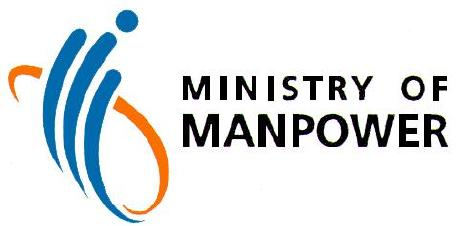

In [83]:
import base64
from IPython.display import Image, display


def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

In [ ]:
# With sources
response = chain_with_sources.invoke("How does multi-head attention work?")
print(f"==>> response: {response}")
print("Response:", response["response"])
print("Context used:", response["context"])
for text in response["context"]["texts"]:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-" * 50 + "\n")
for image in response["context"]["images"]:
    display_base64_image(image)

In [ ]:
# response = vision_chain.invoke("What do the authors mean by 'attention'?")
# print(f"==>> response: {response}")

# print("Response:", response["response"])

# print("\n\nContext:")
# for text in response["context"]["texts"]:
#     print(text.text)
#     print("Page number: ", text.metadata.page_number)
#     print("\n" + "-" * 50 + "\n")
# for image in response["context"]["images"]:
#     display_base64_image(image)

In [ ]:
def test_rag_pipeline(question: str, chain_type: str = "adaptive"):
    """
    Test function to verify RAG pipeline

    Args:
        question: User question
        chain_type: "adaptive", "text_only", or "vision_only"
    """
    print(f"\n=== Testing RAG Pipeline ===")
    print(f"Question: {question}")
    print(f"Chain type: {chain_type}")
    print("-" * 50)

    try:
        if chain_type == "adaptive":
            result = chain.invoke(question)
        elif chain_type == "text_only":
            result = simple_text_chain.invoke(question)
        elif chain_type == "vision_only":
            result = vision_chain.invoke(question)
        else:
            raise ValueError(
                "Invalid chain_type. Use 'adaptive', 'text_only', or 'vision_only'"
            )

        print("Response:")
        print(result)
        return result

    except Exception as e:
        print(f"Error: {e}")
        return None


# Example usage (uncomment to test):
# test_rag_pipeline("What is the attention mechanism?", "adaptive")
# test_rag_pipeline("Explain the transformer architecture", "text_only")

print("RAG pipeline setup complete!")
print(
    f"Available chains: chain (adaptive), simple_text_chain, vision_chain, chain_with_sources"
)